In [2]:
# https://gee-community-catalog.org/projects/annual_nlcd/#earth-engine-snippet
import ee
import xarray as xr
import pandas as pd
import numpy as np
import dask.array as da
import xee
from bbox import * 
from datetime import datetime
import pygeohydro as ph

# Trigger the authentication flow
ee.Authenticate()

# Initialize the Earth Engine library
ee.Initialize(project='satellite-modeling')

# Define the rectangle that encompasses Louisiana and Texas
bbox = ee.Geometry.Rectangle([lon_min, lat_min, lon_max, lat_max])

start_date = '2023-08-01T00:00'
end_date = datetime.now().strftime('%Y-%m-%dT%H:%M')

In [3]:
no2_hours = pd.read_csv("../../data/tempo_data/no2_file_hours.csv")
no2_hours=list(no2_hours['time_hr_ct'])
time_list = np.array(no2_hours, dtype="datetime64[ns]")

In [23]:
##################################################
# Load NDVI Data
##################################################

# List of climate variables to download from NLDAS
variables = ['BurnDate']
# Load NLDAS hourly data and filter by region and date
dataset = ee.ImageCollection("MODIS/061/MCD64A1") \
            .filterDate(start_date, end_date) \
            .filterBounds(bbox)  \
            .select(variables)

ds = xr.open_dataset(dataset, engine='ee', crs='EPSG:4326', scale=0.01)
# Filter the dataset based on the latitude and longitude bounds
ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))


In [34]:
time_list = ds["time"].values.tolist()
time_list=np.array(time_list, dtype="datetime64[ns]")


In [43]:
for time in time_list:
    month_str= str(time.astype('datetime64[M]'))
    ds_month = ds.sel(time=time)
    ds_month=ds_month.fillna(0)
    ds_month.to_netcdf(f'../../data/burned_data/burned_{month_str}.nc')

In [41]:
ds_month

<xarray.Dataset> Size: 2MB
Dimensions:   (lon: 1060, lat: 480)
Coordinates:
    time      datetime64[ns] 8B 2024-09-01
  * lon       (lon) float64 8kB -98.9 -98.89 -98.88 ... -88.32 -88.31 -88.3
  * lat       (lat) float64 4kB 28.61 28.62 28.63 28.64 ... 33.37 33.38 33.39
Data variables:
    BurnDate  (lon, lat) float32 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    crs:      EPSG:4326

In [25]:
ds['BurnDate'].max()

<xarray.DataArray 'BurnDate' ()> Size: 4B
array(364., dtype=float32)

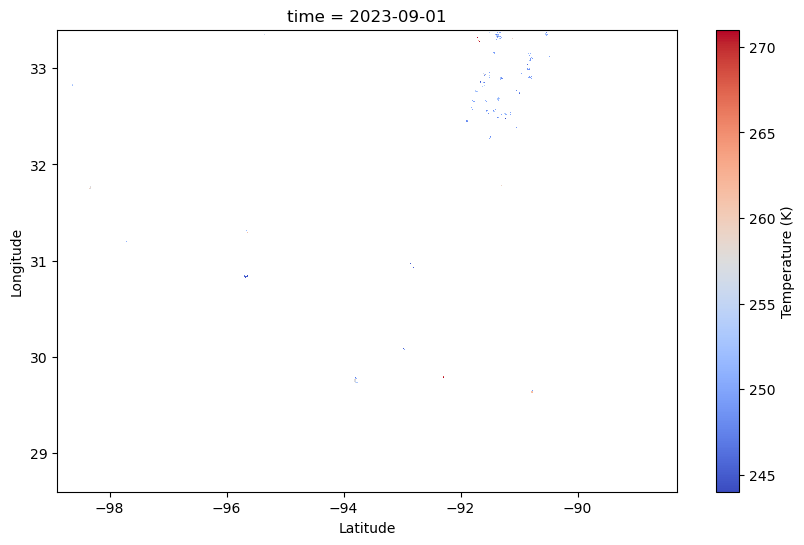

In [44]:
import matplotlib.pyplot as plt
# # Define your latitude and longitude bounds
# lat_min, lat_max = 28.6, 33.4  # Example latitude range
# lon_min, lon_max = -98.9, -88.3  # Example longitude range

# Select one hour of temperature data (e.g., the first timestamp)
hour_index = 2  # Change this to select a different hour if desired
temperature_data = ds['BurnDate'].isel(time=hour_index)
# temperature_data = ds_month['BurnDate']

# temperature_data = ds['Percent_Tree_Cover']

# Plot the data with switched axes
plt.figure(figsize=(10, 6))

# Plot with latitude on x-axis and longitude on y-axis
temperature_data.T.plot(
    cmap="coolwarm",  # Colormap for temperature visualization
    cbar_kwargs={'label': 'Temperature (K)'}  # Add color bar label
)

# Update axis labels
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.show()